In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import astropy.constants as const
import astropy.units as un
from astropy.visualization import quantity_support
import scipy as sp
from scipy.special import kv

In [2]:
#creating the grid x = r/r_lc
N_position = 200
x1 = 1.01
x2 = 2.

X = np.linspace(x1, x2, N_position)*un.dimensionless_unscaled

X_reversed = X[::-1] #reversed matrix for the electron integration



In [3]:
# Values and units of physical constants and other quantities and parameters that are used through the code

e = const.e.esu       #Electron charge
m_e = const.m_e.cgs   #Electron mass
c = const.c.cgs       #Speed of light
h = const.h.cgs       #Planck's constant

r_surface = 10**6 * un.cm  #Surface of the NS
B_surface = 10**13 * un.G  #Magnetic field at the surface of the NS
Period = 0.033 * un.s      #Period of rotation

r_lc = c*Period/(2*np.pi)  #Light cylinder radius
B_lc = B_surface*r_surface**3/(2*r_lc**3)   #Magnetic field at the light cylinder

R_curv = X**2*r_lc   #Radius of curvature of the particle trajectories, calculated analyticaly

#Value of Lorentz factor when the radiation reaction limit is reached
gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)
# gamma_rrl = 4*10**7*(B_surface/(10**13*un.G))**(1/4)*(Period/(1*un.s))**(-1/4)   

v_r = c*np.sqrt(X**2 - 1)**0.5/X    #radial speed as function of radial distance
v_phi = c/X                         #azimuthial speed as function of radial distance

k = 2.   #Pair multiplicity

In [4]:
#Analytical expressions of fields and velocities as a function of the radial distance x

#radial speed 
def v_r(X):
    
    """
    input: X (radial distance)
    output: v_r (radial speed)
    
    description: The radial speed in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    v_r = c*np.sqrt(X**2 - 1)**0.5/X    
    
    return v_r 
    

#azimuthial speed 
def v_phi(X):
    
    """
    input: X (radial distance)
    output: v_phi (azimuthial speed)
    
    description: The azimuthial speed in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    v_phi = c/X
    
    return v_phi


#radial magnetic field
def B_r(X, k = k):
     
    """
    input: X (radial distance), k (multiplicity)
    output: B_r (radial magnetic field)
    
    description: The r component of the magnetic field in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    B_r = B_lc*(1/X**2)*(1-1/X**2)**0.7        
    
    return B_r

#vertical magnetic field
def B_z(X, k = k):
    
    """
    input: X (radial distance), k (multiplicity)
    output: B_z (z magnetic field)
    
    description: The z component of the magnetic field in cgs units, as a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    B_z = -1/(4*k*X)*np.gradient(X*np.sqrt(X**2-1)*B_r(X), X)
    
    return B_z 



#radial electric field    
def E_r(X, k = k):
    
    """
    input: X (radial distance), k (multiplicity)
    output: E_r (radial magnetic field)
   
    description: The r component of the electric field in cgs units as, a function of the dimensionless radial distance X, 
                 as given in Contopoulos, Petri, Stefanou 2019
    """
    
    E_r = -X*B_z(X, k = k)   

In [5]:
#Define the equation that gives the evolution of the Lorentz factor Γ
def eq_of_motion(gamma, X, k, charge_sign):
    
    '''
    input: gamma (lorentz factor), X (radial distance), k (multiplicity), charge_sign 
    output: dgdx (derivative of gamma over X)
    
    description: The derivative of the lorentz factor over the dimensionless radial distance, 
                 as given in Contopoulos, Petri, Stefanou 2019
    '''

    #   Term of numerical constants
    num_term = r_lc*e*B_lc/(m_e*c**2)

    #   Term that depends on the multiplicity k
    k_term = 3/(5*k)*(1-1/(5*k))

    #   Lorentz factor at the radiation reaction limit
    gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)  
    
    
    dgdx = charge_sign*num_term*(k_term*(X**2 - 1)**(-0.3)*X**(-2.4) - (gamma**4/gamma_rrl**4)*X**(-3)*(X**2 - 1)**(-0.5))
    
    return dgdx


In [6]:
#Integrate the equation

gamma_0 = 10.   #initial value of Γ

#positrons
gamma_positron = odeint(eq_of_motion, gamma_0, X, args = (k, +1))        #for positrons
gamma_positron = gamma_positron.reshape(N_position,)*un.dimensionless_unscaled  #reshape the matrix to a convenient form

#electrons
gamma_electron = odeint(eq_of_motion, gamma_0, X_reversed, args = (k, -1))  #for electrons
gamma_electron = gamma_electron.reshape(N_position,)*un.dimensionless_unscaled     #reshape the matrix to a convenient form



In [7]:
print('{:1.2e}, {:1.2e}'.format(max(gamma_electron), max(gamma_positron)))

8.38e+07, 8.43e+07


<IPython.core.display.Javascript object>


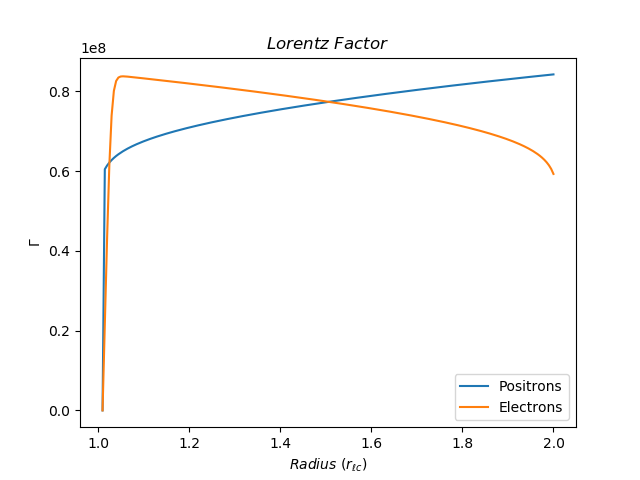

In [13]:
#Plot the evolution of Γ
%matplotlib notebook

# quantity_support()

plt.plot(X, gamma_positron, label = 'Positrons')
plt.plot(X, gamma_electron, label = 'Electrons')
plt.xlabel('$Radius \ (r_{\ell c})$')
plt.ylabel('$\Gamma$')
plt.title('$Lorentz \ Factor$')
plt.legend()
# plt.savefig('ECS_gamma_k2_test.png')

In [9]:
#create a population of charges depending on the radial position



def sigma_electron(X, k = k, P = Period):
     
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : sigma_electron (charge/area)
    
    description: Calculates the surface charge density of the electrons in the ECS as a function of the X,
                 as given in CPS19
                 
    """
    
    s_elec = 2*k*r_lc/(X*v_r(X)*P) * sp.integrate.quad(lambda Y: (Y*B_z(Y)), X, +np.inf)[0]
    
    return s_elec
# print(sigma_electron(X[5]))

def population(X, k = k, P = Period):
    """
    input : X (radial distance), k (multiplicity), P (rotational period of the pulsar)
    output : N(X) (number of particles)
    
    description: Calculates the total number of electrons at some distance X from their surface charge density.
    """
    
    N = 1.*un.dimensionless_unscaled
    
    return N


In [10]:
#Define the curvature radiation spectrum of one particle with given R_c and Γ

def curvature_spectrum(nu, nu_crit, R_curv, gamma):
     
    '''
    input : nu (frequency), nu_crit (critical frequency), R_curv (radius of curvature), gamma (lorentz factor)
    output : power(nu) (spectrum)
    
    description: The spectrum of curvature radiation from a particle moving with lorentz factor gamma 
                 in a curved trajectory of radius R_curv.
    '''
    
    integral = sp.integrate.quad(lambda z: kv(5./3., z), nu/nu_crit, +np.inf)[0]*un.dimensionless_unscaled
    
    power = np.sqrt(3)*e**2/(2*np.pi)*gamma/R_curv*nu/nu_crit*integral
    
    return power


In [42]:
#Calculate the spectrum of the particles


#Frequency grid
N_frequency = 100        #Number of frequencies in which the spectrum is calculated
f1 = 20                  #Minimum 
f2 = 30                  #Maximum 
frequency = np.logspace(f1, f2, N_frequency)*un.Hz       #Frequencies distributed evenly in a logarithmic space
photon_energy = (frequency*h).to(un.eV)                  #Corresponding energies in eV

positron_number = 1000*np.ones(N_position)
electron_number = 1000*np.ones(N_position)


#Critical frequency for curvature radition
nu_crit_positron = 3*c/2*gamma_positron**3/R_curv        
nu_crit_electron = 3*c/2*gamma_electron**3/R_curv        

#Initializing the matrix of the instantaneous power per frequency
instant_ppf_positron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)     #units correspond to power per
instant_ppf_electron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)     #frequency: (erg/s)/Hz = erg

#Initializing the matrix of the power per frequency of the trajectory
traj_ppf_positron = np.zeros((N_frequency))*instant_ppf_positron.unit
traj_ppf_electron = np.zeros((N_frequency))*instant_ppf_electron.unit

#Initializing the matrix of the total power per frequency (entire trajectory + population of particles)
total_ppf_positron = np.zeros((N_frequency))*instant_ppf_positron.unit
total_ppf_electron = np.zeros((N_frequency))*instant_ppf_electron.unit

#----------------------------------------------------------------------------------------------

#Spectrum calculation
for nu in range(N_frequency-1):
    for i in range(N_position-1):
        
        #Positrons
        
        #the instantaneous power per frequency emitted by a positron in position X
        instant_ppf_positron[nu][i] = curvature_spectrum(frequency[nu], nu_crit_positron[i], R_curv[i], gamma_positron[i])
        
        #the power per frequency emitted along the whole trajectory
        traj_ppf_positron[nu] += instant_ppf_positron[nu][i]
        
        #the total power per frequency emitted by all the positrons
        total_ppf_positron[nu] += positron_number[i]*instant_ppf_positron[nu][i]
        
    # ---------------------------------------------------------------------------------------------
        
        #Electrons
        
        #the instantaneous power per frequency emitted by a positron in position X
        instant_ppf_electron[nu][i] = curvature_spectrum(frequency[nu], nu_crit_electron[i], R_curv[i], gamma_electron[i])
        
        #the total power per frequency emitted along the whole trajectory
        traj_ppf_electron[nu] += instant_ppf_electron[nu][i]
        
        #the total power per frequency emitted by all the electrons
        total_ppf_electron[nu] += electron_number[i]*instant_ppf_electron[nu][i]

In [43]:
# The total radiated power by the positrons
power_positron = frequency*total_ppf_positron

# The total radiated power by the electrons
power_electron = frequency*total_ppf_electron

<IPython.core.display.Javascript object>


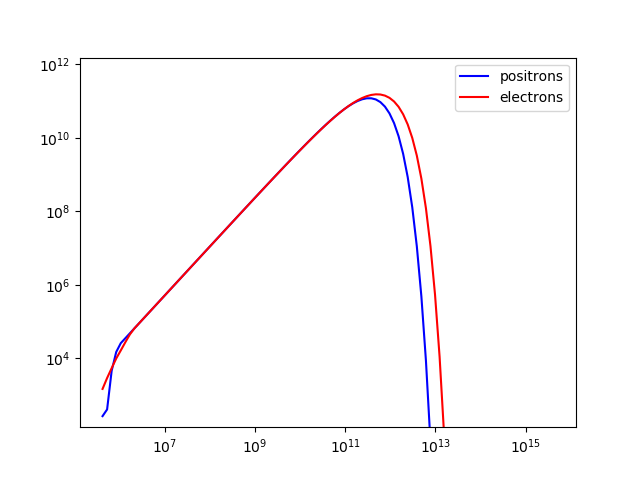

In [50]:
# Spectrum plots
%matplotlib notebook


fig, ax = plt.subplots()


ax.plot(photon_energy, power_positron, label = 'positrons', c = 'b')
ax.plot(photon_energy, power_electron, label = 'electrons', c = 'r')


# ax.plot(photon_energy, frequency*traj_ppf_positron, label = 'trajectory', c = 'b')
# for i in range(N_position):
#     ax.plot(photon_energy, frequency*instant_ppf_positron[:,i], c = 'r')

ax.set_xscale('log')
ax.set_yscale('log')

#set limits depending on the depicted values
ax.set_ylim(bottom = 0.5*min(power_positron[0].value, power_electron[0].value), 
            top = 10*max(max(power_positron.value), max(power_electron.value)))
ax.legend()

13